In [56]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from itertools import product

C:\Users\Kamir\AppData\Local\Temp\ipykernel_79744\4010826365.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [82]:
class SMABacktester ():
    def __init__(self, symbol,sma_s,sma_l,start,end):
        '''
        Parameters
        ----------
        symbol: str
            ticker symbol(instrument) to be backtested
        sma_s:int
            moving window in bars for shorter sma
        sma_l:int
            monving window in bars for longer sma
        '''
        self.symbol=symbol
        self.sma_s=sma_s
        self.sma_l=sma_l
        self.start=start
        self.end=end
        self.results=None 
        self.get_data()
        self.prepare_data()
        
    def get_data(self) : 
        raw=pd.read_csv("fx_pairs.csv", parse_dates=["Date"], index_col="Date").copy()
        raw=raw[self.symbol].to_frame().dropna()
        raw=raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol:"price"}, inplace=True) #changing the column name
        self.data=raw
        return raw
    
    def prepare_data(self):
        raw = self.data.copy().dropna() 
        raw["returns"]=np.log(raw.price/raw.price.shift())
        raw["sma_s"]=raw.price.rolling(self.sma_s).mean()
        raw["sma_l"]=raw.price.rolling(self.sma_l).mean()
        self.data=raw
        return raw
    
    def set_parameters(self, sma_s= None, sma_l= None):
        if sma_s is not None: 
            self.sma_s= sma_s
            self.data["sma_s"]=self.data["price"].rolling(self.sma_s).mean()
        if sma_l is not None:
            self.sma_l= sma_l
            self.data["sma_l"]=self.data["price"].rolling(self.sma_l).mean()
    
    def test_strategy(self):
        data=self.data.copy().dropna()
        data["position"]=np.where(data["sma_s"]>data["sma_l"],1,-1)
        data["strategy"]=data["position"].shift()*data["returns"]
        data.dropna()
        data["creturns"]=data["returns"].cumsum().apply(np.exp)
        data["cstrategy"]=data["strategy"].cumsum().apply(np.exp)
        self.results=data
        
        perf=data["cstrategy"].iloc[-1]
        outperf=perf - data["creturns"].iloc[-1]
        return round(perf,6), round(outperf,6)
    
    
    def plot_results(self):
        if self.results is None:
            print("Run test_strategy() first")
        else:
            title="{} | sma_s={} | sma_l={}".format(self.symbol,self.sma_s,self.sma_l)
            self.results[["creturns","cstrategy"]].plot(title=title, figsize=(15,8))
            
    def optimize_parameters(self,sma_s_range,sma_l_range):
        combinations = list(product(range(*sma_s_range),range(*sma_l_range)))
        
        results=[]
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            results.append(self.test_strategy()[0])
        
        best_perf = np.max(results) #best performance
        opt= combinations[np.argmax(results)] #optimal parameters
        
        #set the optimal strategy
        self.set_parameters(opt[0],opt[1])
        self.test_strategy
        
        #create a df with many results
        many_results= pd.DataFrame(data=combinations, columns=["sma_s","sma_l"])
        many_results["performance"]=results
        self.results_overview=many_results
        best_results = many_results.nlargest(10,"performance")
        return opt, best_perf, best_results

In [80]:
tester = SMABacktester("EURUSD=X", 50, 200,"2004-01-01", "2023-08-31")

In [81]:
tester

In [74]:
tester.get_data()

,price
Date,
2004-01-01,1.258194
2004-01-02,1.258194
2004-01-05,1.268698
2004-01-06,1.272103
2004-01-07,1.264095
...,...
2023-08-25,1.079914
2023-08-28,1.079739
2023-08-29,1.082556


In [39]:
tester.prepare_data()

,price,returns,sma_s,sma_l
Date,,,,
2004-01-01,1.258194,NaN,NaN,NaN
2004-01-02,1.258194,0.000000,NaN,NaN
2004-01-05,1.268698,0.008313,NaN,NaN
2004-01-06,1.272103,0.002681,NaN,NaN
2004-01-07,1.264095,-0.006315,NaN,NaN
...,...,...,...,...
2023-08-25,1.079914,-0.006153,1.098166,1.080429
2023-08-28,1.079739,-0.000162,1.097876,1.080663
2023-08-29,1.082556,0.002606,1.097679,1.080952


In [50]:
tester.test_strategy()

(1.484389, 0.596721)

In [52]:
tester.results

,price,returns,sma_s,sma_l,position,strategy,creturns,cstrategy
Date,,,,,,,,
2004-10-06,1.228094,-0.002853,1.221318,1.226222,-1,NaN,0.997151,NaN
2004-10-07,1.229906,0.001475,1.221840,1.226081,-1,-0.001475,0.998623,0.998526
2004-10-08,1.241003,0.008982,1.222628,1.225995,-1,-0.008982,1.007632,0.989598
2004-10-11,1.238405,-0.002095,1.223352,1.225843,-1,0.002095,1.005523,0.991673
2004-10-12,1.232104,-0.005102,1.223888,1.225643,-1,0.005102,1.000407,0.996746
...,...,...,...,...,...,...,...,...
2023-08-25,1.079914,-0.006153,1.098166,1.080429,1,-0.006153,0.876836,1.466275
2023-08-28,1.079739,-0.000162,1.097876,1.080663,1,-0.000162,0.876694,1.466037
2023-08-29,1.082556,0.002606,1.097679,1.080952,1,0.002606,0.878981,1.469862


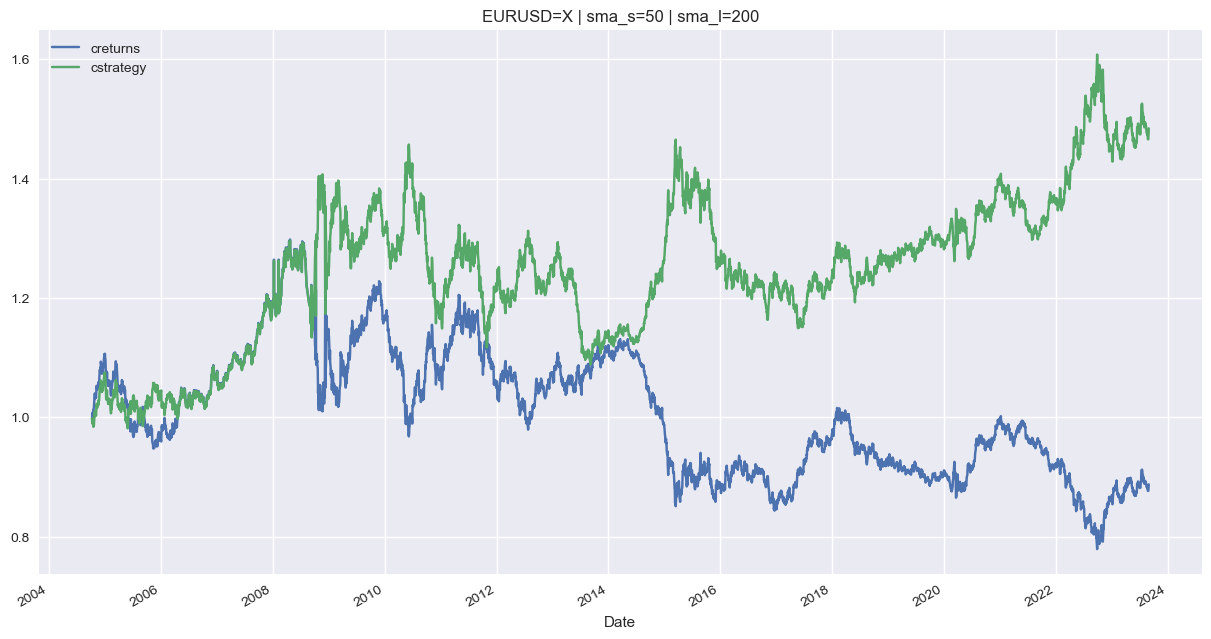

In [53]:
tester.plot_results()

In [65]:
tester.optimize_parameters((10,50,1),(100,200,1))

((46, 137),
 2.853883,
       sma_s  sma_l  performance
 3637     46    137     2.853883
 3736     47    136     2.822695
 3536     45    136     2.813014
 1960     29    160     2.805957
 2827     38    127     2.805232
 2828     38    128     2.788284
 1962     29    162     2.783586
 1862     28    162     2.783012
 1861     28    161     2.774723
 3436     44    136     2.772191)